Dataset shape: (12020, 2)


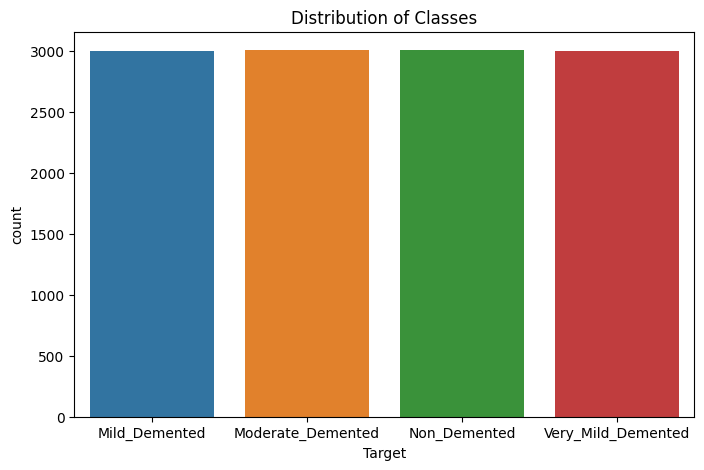

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


In [38]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/kaggle/input/pre-processed-dataset/AD_AUG"
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
    dataframe = load_data(DATA_PATH)
explore_data(dataframe)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)


# **build_resnet50**

Training ResNet50...
Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.2593 - loss: 11.9227 - val_accuracy: 0.3161 - val_loss: 11.0114 - learning_rate: 1.0000e-06
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.3529 - loss: 11.3788 - val_accuracy: 0.5491 - val_loss: 10.3349 - learning_rate: 1.0000e-06
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.4330 - loss: 11.0188 - val_accuracy: 0.6306 - val_loss: 10.1368 - learning_rate: 1.0000e-06
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.4863 - loss: 10.7984 - val_accuracy: 0.6955 - val_loss: 10.0060 - learning_rate: 1.0000e-06
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.5524 - loss: 10.6339 - val_accuracy: 0.7408 - val_loss: 9.9163 - learning_rate: 1.0000e-06
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.5937 - loss: 10.4584 - val_accuracy: 0.7837 - val_loss: 9.8400 - learning_rate: 1.0000e-06
Epoch 7/50
601/601 ━━

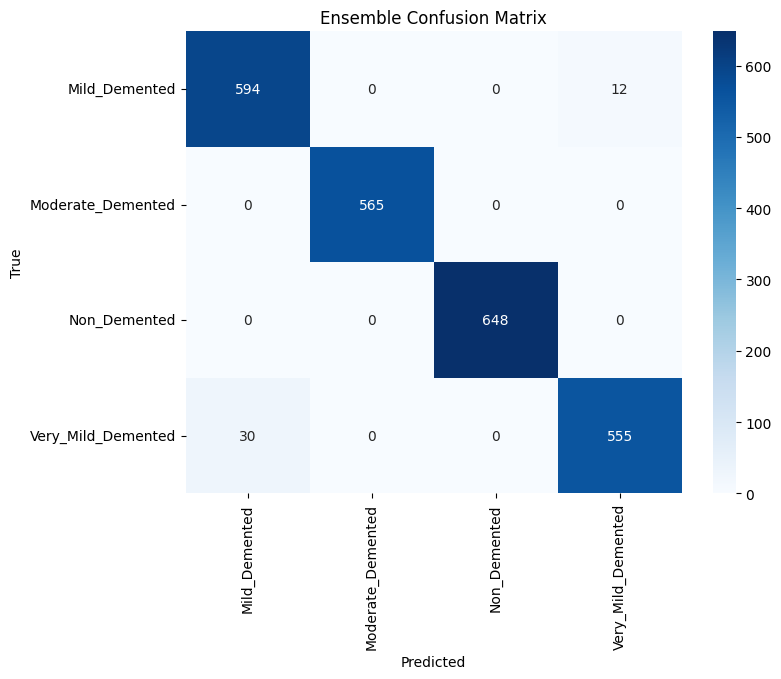

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, DenseNet169
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Pre-trained Models
input_shape = (128, 128, 3)  # Assuming RGB images
num_classes = len(train_data.class_indices)  # Get number of classes

# ResNet50 Model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50 = resnet50_base.output
resnet50 = GlobalAveragePooling2D()(resnet50)
resnet50 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(resnet50)  # L2 Regularization
resnet50 = BatchNormalization()(resnet50)  # Batch Normalization
resnet50 = Dropout(0.7)(resnet50)  # Dropout for regularization
resnet50 = Dense(num_classes, activation='softmax')(resnet50)
resnet50_model = Model(inputs=resnet50_base.input, outputs=resnet50)

# DenseNet169 Model
densenet169_base = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
densenet169 = densenet169_base.output
densenet169 = GlobalAveragePooling2D()(densenet169)
densenet169 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(densenet169)  # L2 Regularization
densenet169 = BatchNormalization()(densenet169)  # Batch Normalization
densenet169 = Dropout(0.7)(densenet169)  # Dropout for regularization
densenet169 = Dense(num_classes, activation='softmax')(densenet169)
densenet169_model = Model(inputs=densenet169_base.input, outputs=densenet169)

# Step 2: Compile Both Models with Label Smoothing
def categorical_crossentropy_with_label_smoothing(y_true, y_pred, label_smoothing=0.1):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

resnet50_model.compile(optimizer=Adam(learning_rate=0.000001, clipvalue=1.0),  # Gradient clipping
                       loss=categorical_crossentropy_with_label_smoothing,
                       metrics=['accuracy'])

densenet169_model.compile(optimizer=Adam(learning_rate=0.000001, clipvalue=1.0),  # Gradient clipping
                          loss=categorical_crossentropy_with_label_smoothing,
                          metrics=['accuracy'])

# Step 3: Add Callbacks for Early Stopping, Learning Rate Reduction, and Model Checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)  # More aggressive LR reduction
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Step 4: Train Both Models Individually
print("Training ResNet50...")
resnet50_history = resnet50_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Increase epochs but use early stopping
    batch_size=16,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

print("Training DenseNet169...")
densenet169_history = densenet169_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Increase epochs but use early stopping
    batch_size=16,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Step 5: Combine Predictions (Ensemble)
def ensemble_predictions(models, test_data):
    predictions = []
    for model in models:
        pred = model.predict(test_data)
        predictions.append(pred)
    # Average the predictions
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

# Get the ensemble predictions
models = [resnet50_model, densenet169_model]
y_pred_ensemble = ensemble_predictions(models, test_data)

# Step 6: Evaluate the Ensemble
y_true = test_data.classes

# Classification Report
print("Ensemble Classification Report:")
print(classification_report(y_true, y_pred_ensemble, target_names=list(train_data.class_indices.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(train_data.class_indices.keys()), yticklabels=list(train_data.class_indices.keys()))
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **build DenseNet169**

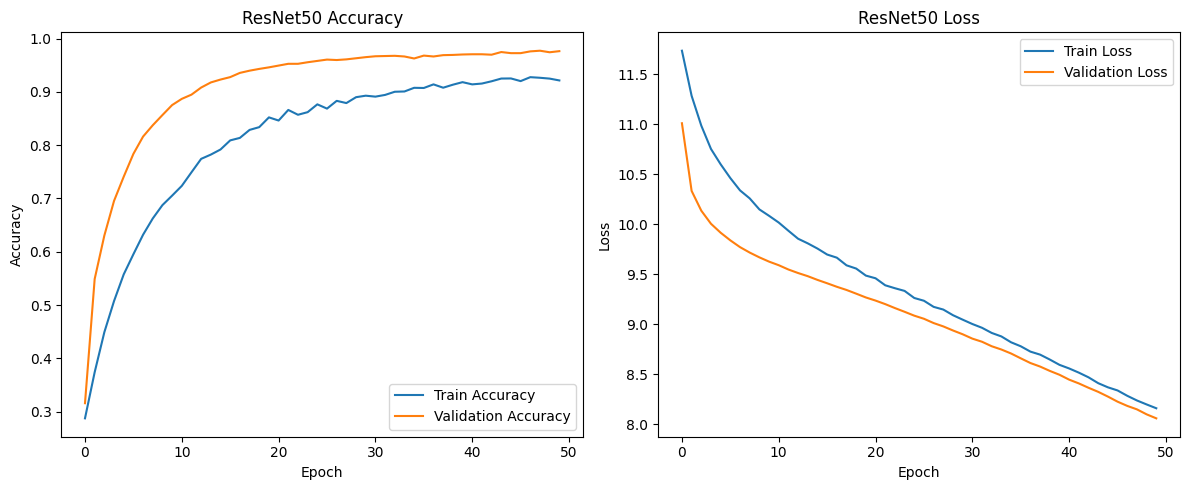

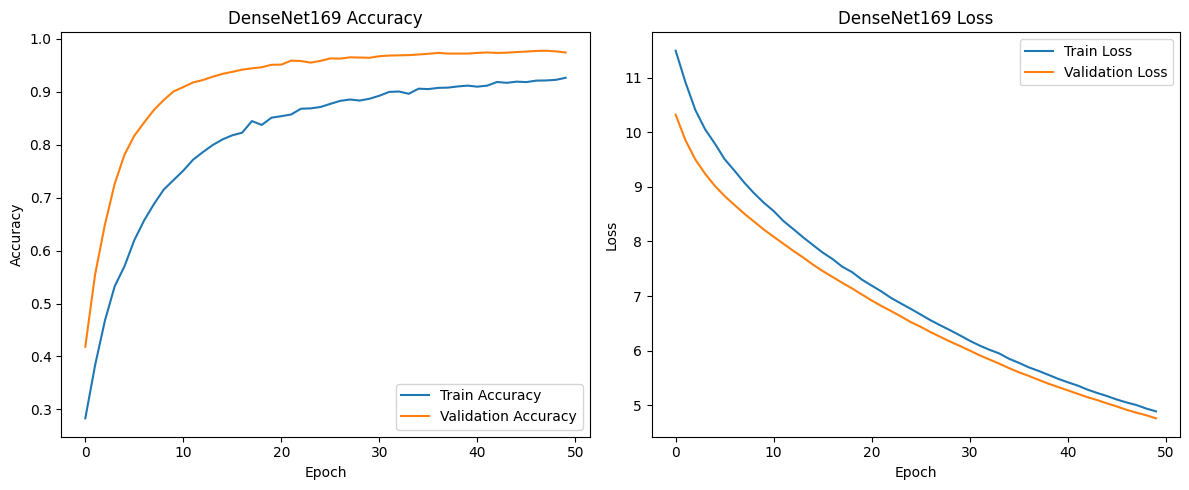

In [40]:
# Plot ResNet50 training history
plot_training_history(resnet50_history, 'ResNet50')

# Plot DenseNet169 training history
plot_training_history(densenet169_history, 'DenseNet169')

# **Train Individual Models**

In [41]:
 # Evaluate ResNet50 on test data
resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate(test_data)
print(f"ResNet50 Test Accuracy: {resnet50_test_accuracy:.4f}")
print(f"ResNet50 Test Loss: {resnet50_test_loss:.4f}")
# Evaluate DenseNet169 on test data
densenet169_test_loss, densenet169_test_accuracy = densenet169_model.evaluate(test_data)
print(f"DenseNet169 Test Accuracy: {densenet169_test_accuracy:.4f}")
print(f"DenseNet169 Test Loss: {densenet169_test_loss:.4f}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9770 - loss: 8.0602
ResNet50 Test Accuracy: 0.9763
ResNet50 Test Loss: 8.0596
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9681 - loss: 4.7625
DenseNet169 Test Accuracy: 0.9742
DenseNet169 Test Loss: 4.7566


In [42]:
# Get predictions from both models
resnet50_preds = resnet50_model.predict(test_data)
densenet169_preds = densenet169_model.predict(test_data)

# Average the predictions
ensemble_preds = (resnet50_preds + densenet169_preds) / 2

# Convert predictions to class labels
ensemble_pred_classes = np.argmax(ensemble_preds, axis=1)

# True labels
y_true = test_data.classes

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(ensemble_pred_classes == y_true)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Ensemble Test Accuracy: 0.9825


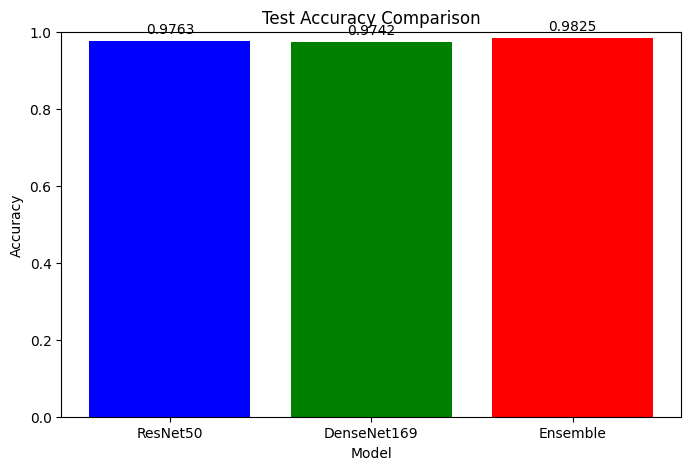

In [43]:
import matplotlib.pyplot as plt

# Data
models = ['ResNet50', 'DenseNet169', 'Ensemble']
accuracies = [resnet50_test_accuracy, densenet169_test_accuracy, ensemble_accuracy]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # Set y-axis limit between 0 and 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


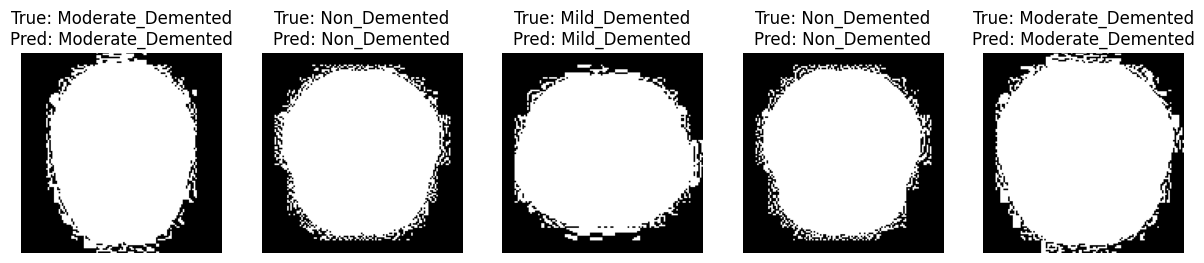

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to predict and display results
def predict_and_display(test_data, resnet50_model, densenet169_model, class_names, num_samples=5):
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    # Predict using ResNet50
    resnet50_preds = resnet50_model.predict(test_images)
    resnet50_pred_classes = np.argmax(resnet50_preds, axis=1)

    # Predict using DenseNet169
    densenet169_preds = densenet169_model.predict(test_images)
    densenet169_pred_classes = np.argmax(densenet169_preds, axis=1)

    # Ensemble predictions (average probabilities)
    ensemble_preds = (resnet50_preds + densenet169_preds) / 2
    ensemble_pred_classes = np.argmax(ensemble_preds, axis=1)

    # True labels
    true_classes = np.argmax(test_labels, axis=1)

    # Display predictions for a few samples
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')  # Display grayscale image
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[ensemble_pred_classes[i]]}")
        plt.axis('off')
    plt.show()

     
# Class names (replace with your actual class names)
class_names = list(test_data.class_indices.keys())

# Call the function to predict and display results
predict_and_display(test_data, resnet50_model, densenet169_model, class_names, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


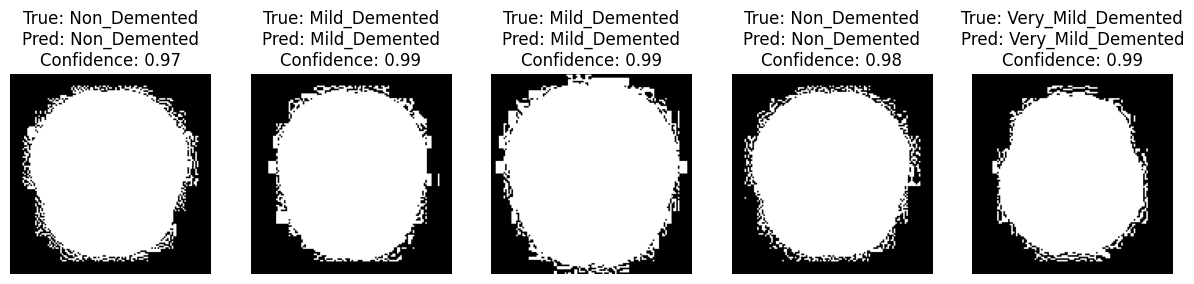

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to predict and display results with confidence level
def predict_and_display_with_confidence(test_data, resnet50_model, densenet169_model, class_names, num_samples=5):
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    # Predict using ResNet50
    resnet50_preds = resnet50_model.predict(test_images)
    resnet50_pred_classes = np.argmax(resnet50_preds, axis=1)

    # Predict using DenseNet169
    densenet169_preds = densenet169_model.predict(test_images)
    densenet169_pred_classes = np.argmax(densenet169_preds, axis=1)

    # Ensemble predictions (average probabilities)
    ensemble_preds = (resnet50_preds + densenet169_preds) / 2
    ensemble_pred_classes = np.argmax(ensemble_preds, axis=1)

    # True labels
    true_classes = np.argmax(test_labels, axis=1)

    # Display predictions for a few samples with confidence level
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        # If images are grayscale, use cmap='gray' and ensure proper scaling
        if test_images[i].shape[-1] == 1:
            plt.imshow(test_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)  # Ensure proper scaling
        else:
            plt.imshow(test_images[i])  # For RGB images
        
        # Get the predicted class and confidence level
        predicted_class = class_names[ensemble_pred_classes[i]]
        confidence = np.max(ensemble_preds[i])  # Confidence level for the predicted class
        true_class = class_names[true_classes[i]]
        
        # Display the true class, predicted class, and confidence level
        plt.title(f"True: {true_class}\nPred: {predicted_class}\nConfidence: {confidence:.2f}")
        plt.axis('off')
    plt.show()

    

# Class names (replace with your actual class names)
class_names = list(test_data.class_indices.keys())

# Call the function to predict and display results with confidence level
predict_and_display_with_confidence(test_data, resnet50_model, densenet169_model, class_names, num_samples=5)